In [42]:
import numpy as np

# Designing the world & Setting the rules



Build the reward matrix

In [46]:
def initialize_rewards(grid_size, r):
    num_states = grid_size * grid_size
    rewards = -1 * np.ones(num_states)
    rewards[position_to_state(0, 0, grid_size)] = r  # Terminal state 'r'
    rewards[position_to_state(0, 2, grid_size)] = 10  # Terminal state +10
    return rewards

for the move function, you either move up,down, left or right, the max and min functions clip the worldto ensure moves are legal

In [48]:
def move(row, col, action,grid_size):
    new_row, new_col = row, col  # Initialize new position with current position

    if action == 0 and row != 0:  # Up, but not at the top row
        new_row = max(0, row - 1)
    elif action == 1 and row != 3 - 1:  # Down, but not at the bottom row
        new_row = min(3 - 1, row + 1)
    elif action == 2 and col != 3 - 1:  # Right, but not at the rightmost column
        new_col = min(3 - 1, col + 1)
    elif action == 3 and col != 0:  # Left, but not at the leftmost column
        new_col = max(0, col - 1)

    return new_row, new_col


for the transition probabilities, the intended move has probability = 0.8, perpendicular moves have 0.1 each, if a move is illegal then the probability to stay in place = probability of the illegal move, the move function takes care of this

In [45]:
def initialize_transition_probs(grid_size):
    num_states = grid_size * grid_size
    num_actions = 4  # Up, Down, Right, Left
    transition_probs = np.zeros((num_states, num_actions, num_states))
    for s in range(num_states):
        row, col = state_to_position(s, grid_size)
        for a in range(num_actions):
            for offset, prob in [(0, 0.8), (2, 0.1), (-2, 0.1)]:
                next_row, next_col = move(row, col, (a + offset) % 4, grid_size)
                next_s = position_to_state(next_row, next_col, grid_size)
                transition_probs[s, a, next_s] += prob
    return transition_probs


def state_to_position(state, grid_size):
    row = state // grid_size
    col = state % grid_size
    return row, col

def position_to_state(row, col, grid_size):
    return row * grid_size + col


# VALUE ITERATION
using bellman update rule

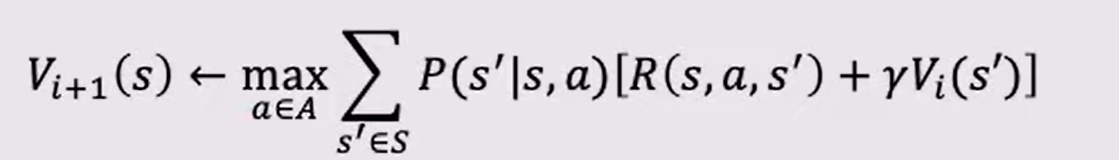

In [56]:
def value_iteration(grid_size, r):
    num_states = grid_size * grid_size
    transition_probs = initialize_transition_probs(grid_size)
    rewards = initialize_rewards(grid_size, r)
    discount_factor = 0.99

    value_function = np.zeros(num_states)
    value_function[0]=r
    value_function[2]=10
    theta = 0.001
    while True:
        for s in range(num_states):
            if s in [0,2]:
                continue
            v = value_function[s]
            value_function[s] = max(
                sum(transition_probs[s, a, s_prime] * (rewards[s] + discount_factor * value_function[s_prime])
                    for s_prime in range(num_states)) for a in range(4))
            delta = abs(v - value_function[s])
        if delta < theta:
            break
    policy = np.zeros(num_states, dtype=int)
    for s in range(num_states):
        if s in [0,2]:  # Skip terminal states
            continue
        row, col = state_to_position(s, grid_size)
        best_value = float('-inf')
        best_action = None
        for action in range(4):
            next_row, next_col = move(row, col, action, grid_size)
            if 0 <= next_row < grid_size and 0 <= next_col < grid_size:
                next_state = position_to_state(next_row, next_col, grid_size)
                if value_function[next_state] > best_value:
                    best_value = value_function[next_state]
                    best_action = action
        policy[s] = best_action

    # Define action names mapping
    action_names = {
        0: '↑',
        1: '↓',
        2: '→',
        3: '←',
    }

    # Convert policy from numerical actions to action names
    policy_with_names = [action_names[action] for action in policy]
    policy_with_names[0] = 'T'
    policy_with_names[2] = 'T'
    return value_function, policy_with_names


def test_value_iteration():
    grid_size = 3
    rs = [100, 3, 0, -3]
    for r in rs:
        value_function, policy = value_iteration(grid_size, r)
        print(f"For r={r}:")
        print("Value Function:")
        print(value_function.reshape((grid_size, grid_size)))
        print("Policy:")
        print(np.array(policy).reshape((grid_size, grid_size)))
        print()

print("testing value iteration")
test_value_iteration()

testing value iteration
For r=100:
Value Function:
[[100.          96.75319987  10.        ]
 [ 96.75319987  93.70344811  90.81569326]
 [ 93.70344811  91.28804472  88.90269378]]
Policy:
[['T' '←' 'T']
 ['↑' '↑' '←']
 ['↑' '↑' '←']]

For r=3:
Value Function:
[[ 3.          8.62840855 10.        ]
 [ 5.56723245  7.54210811  8.62840855]
 [ 5.18132924  6.41346347  7.27381341]]
Policy:
[['T' '→' 'T']
 ['→' '↑' '↑']
 ['→' '↑' '↑']]

For r=0:
Value Function:
[[ 0.          8.62840855 10.        ]
 [ 4.97323245  7.54210811  8.62840855]
 [ 5.06371724  6.41346347  7.27381341]]
Policy:
[['T' '→' 'T']
 ['→' '↑' '↑']
 ['→' '↑' '↑']]

For r=-3:
Value Function:
[[-3.          8.62840855 10.        ]
 [ 4.37923245  7.54210811  8.62840855]
 [ 4.94610524  6.41346347  7.27381341]]
Policy:
[['T' '→' 'T']
 ['→' '↑' '↑']
 ['→' '↑' '↑']]



the greater the value of r, the more it pulls, Therefore for r = 100 optimal policy would involve moving left then up, towards upper left corner, for other values of r, top right corner is more attractive since it has greater value "10"

# POLICY ITERATION

Initialise with a random policy
iterate through the steps below
calculate value function for policy
try to find a policy that further improves the current policy, use one step lookahead
chech for convergence by checking if policy remains the same, break


In [63]:
def initialize_random_policy(grid_size):
    num_states = grid_size * grid_size
    policy = np.zeros(num_states, dtype=int)
    for s in range(num_states):
        row, col = state_to_position(s, grid_size)
        # Get list of legal actions for the current state
        legal_actions = []
        if row > 0:  # Up is possible
            legal_actions.append(0)  # Up
        if row < grid_size - 1:  # Down is possible
            legal_actions.append(1)  # Down
        if col < grid_size - 1:  # Right is possible
            legal_actions.append(2)  # Right
        if col > 0:  # Left is possible
            legal_actions.append(3)  # Left
        # Randomly select an action from the legal actions
        policy[s] = np.random.choice(legal_actions)
    return policy

def evaluate_policy(policy, grid_size, r):
    num_states = grid_size * grid_size
    transition_probs = initialize_transition_probs(grid_size)
    rewards = initialize_rewards(grid_size, r)
    discount_factor = 0.99
    value_function = np.zeros(num_states)
    theta = 0.001
    while True:
        delta = 0
        for s in range(num_states):
            if s in [0,2]:  # Skip terminal states
                value_function[s] = rewards[s]  # Set value of terminal states directly
                continue
            v = value_function[s]
            action = policy[s]
            next_row, next_col = move(*state_to_position(s, grid_size), action, grid_size)
            next_state = position_to_state(next_row, next_col, grid_size)
            value_function[s] = transition_probs[s, action, next_state] * (
                        rewards[s] + discount_factor * value_function[next_state])
            delta = max(delta, abs(v - value_function[s]))
        if delta < theta:
            break
    return value_function

def improve_policy(value_function, policy, grid_size, r):
    num_states = grid_size * grid_size
    transition_probs = initialize_transition_probs(grid_size)
    rewards = initialize_rewards(grid_size, r)
    new_policy = np.zeros(num_states, dtype=int)
    for s in range(num_states):
        if s in [0,2]:  # Skip terminal states
            continue
        row, col = state_to_position(s, grid_size)
        best_value = float('-inf')
        best_action = None
        for action in range(4):
            next_row, next_col = move(row, col, action, grid_size)
            next_state = position_to_state(next_row, next_col, grid_size)
            if value_function[next_state] > best_value:
                best_value = value_function[next_state]
                best_action = action
        new_policy[s] = best_action
    return new_policy


def policy_iteration(grid_size, r):
    policy = initialize_random_policy(grid_size)
    while True:
        value_function = evaluate_policy(policy, grid_size, r)
        new_policy = improve_policy(value_function, policy, grid_size,r)
        if np.array_equal(new_policy, policy):
            break
        policy = new_policy
    return value_function, policy


def decode_policy(policy):

    action_names = {
        0: '↑',
        1: '↓',
        2: '→',
        3: '←',
    }
    policy_with_names = [action_names[action] for action in policy]
    policy_with_names[0] = 'T'
    policy_with_names[2] = 'T'
    return policy_with_names

def test_policy_iteration():
    grid_size = 3
    rs = [100, 3, 0, -3]
    for r in rs:
        value_function, policy = policy_iteration(grid_size, r)
        print(f"For r={r}:")
        print("Value Function:")
        print(value_function.reshape((grid_size, grid_size)))
        print("Policy:")
        print(np.array(decode_policy(policy)).reshape((grid_size, grid_size)))
        print()


print("testing Policy Iteration")
test_policy_iteration()



testing Policy Iteration
For r=100:
Value Function:
[[100.         78.4        10.       ]
 [ 78.4        61.2928     47.7438976]
 [ 61.2928     47.7438976  37.0131669]]
Policy:
[['T' '←' 'T']
 ['↑' '↑' '←']
 ['↑' '↑' '↑']]

For r=3:
Value Function:
[[ 3.          7.12       10.        ]
 [ 3.03251968  4.83904     7.12      ]
 [ 1.60175559  3.03251968  4.83904   ]]
Policy:
[['T' '→' 'T']
 ['→' '↑' '↑']
 ['↑' '↑' '↑']]

For r=0:
Value Function:
[[ 0.          7.12       10.        ]
 [ 3.03251968  4.83904     7.12      ]
 [ 1.60175559  3.03251968  4.83904   ]]
Policy:
[['T' '→' 'T']
 ['→' '↑' '↑']
 ['↑' '↑' '↑']]

For r=-3:
Value Function:
[[-3.          7.12       10.        ]
 [ 3.03251968  4.83904     7.12      ]
 [ 1.60175559  3.03251968  4.83904   ]]
Policy:
[['T' '→' 'T']
 ['→' '↑' '↑']
 ['↑' '↑' '↑']]

